# LGM-VIP Data Science Internship Programme
# Beginner Level Task-3
# Task name: Music Recommendation


**Candidate Name : Ebin Noufel**

**Problem Description**

WSDM (International Conference on Web Search and Data Mining) has given a challenge to the Kaggle community to build better music recommendation system using a donated dataset from KKBOX.
Given set of features we have to predict wether the user would like to listen the recommneded song or not.

 **Machine Learning problem formulation**

Here we have to predict the probability of a user listening to a song on loop. When the user listens to a song on loop over a month of listening to songs, its target is marked as 1 and 0 otherwise .
KKBOX has provided a training data set consists of information of the first observable listening event for each unique user-song pair within a specific time duration.

Source : https://www.kaggle.com/c/kkbox-music-recommendation-challenge/data


Total 5 data files are 

**train.csv** : 

user_id (msno),

song_id,

source_system_tab (where the event was triggered),

source_type (an entry point a user first plays music),

source_screen_name (name of the layout user sees),

target (​ 1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0​ otherwise ).

**test.csv** : Contains fields same as above except target, which we have to predict.

**songs.csv**: It includes fields like

song_id,

song_length,

genre_id,

artist_name,

composer,

lyricist

lanugage.

**members.csv**: It contains attributes like

msno (user_id),

city,

bd (may contains outliers),

gender,

register_via (register method),

register_init_time (date),

expirartion_date (date).

song_extra_info.csv : This file contains

song_id,

song_name

**ISRC (International Standard Recording Code) used to identify songs**.

-> Example data point

**train**:

msno : Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=

song_id : bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=

source_system_tab : my library

source_screen_name : Local playlist more

source_type : local-playlist

target : 1

**test**:

id : 1

msno : V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=

song_id : y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=

source_system_tab : my library

source_screen_name : local playlist more

source_type : local-library

**songs**:

song_id : o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=

song_length : 197328

genre_ids : 444

artist_name : BLACKPINK

composer : TEDDY| FUTURE BOUNCE| Bekuh 

lyricist : TEDDY

language : 31

**songs_extra_info**:

song_id : ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=

name : Let Me Love You

isrc : QMZSY1600015

**members**:

msno : UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=

city : 1

bd : 0

gender : NaN

registered_via : 7

registration_init_time : 20150628

expiration_date : 20170622

We are given two classes 0/1 hence we can map this problem as a binary classification problem.

-> **Performance metric**

There is no clear instructions about performance metric so we will consider AUC.

In [2]:
# Importing basic libraries
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import missingno as msno
import gc
import lightgbm as lgb
from xgboost import XGBClassifier

Reading files from respective paths

In [3]:
#data_path = '/Data'
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
songs = pd.read_csv('songs.csv')
members = pd.read_csv('members.csv')
song_extra_info = pd.read_csv('song_extra_info.csv')

Printing shapes and features for each file.

In [4]:
print('Shape of train file is : ', train.shape)
print('Shape of test file is : ', test.shape)
print('Shape of songs file is : ', songs.shape)
print('Shape of members file is : ', members.shape)
print('Shape of songs_extra_info file is : ', song_extra_info.shape)

Shape of train file is :  (2528892, 6)
Shape of test file is :  (2474599, 6)
Shape of songs file is :  (2296320, 7)
Shape of members file is :  (34403, 7)
Shape of songs_extra_info file is :  (2295971, 3)


In [5]:
print('Features of train : ', train.columns)
print('Features of test :', test.columns)
print('Features of songs : ', songs.columns)
print('Features of members : ', members.columns)
print('Features of songs_extra_info : ', song_extra_info.columns)

Features of train :  Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target'],
      dtype='object')
Features of test : Index(['id', 'msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type'],
      dtype='object')
Features of songs :  Index(['song_id', 'song_length', 'genre_ids', 'artist_name', 'composer',
       'lyricist', 'language'],
      dtype='object')
Features of members :  Index(['msno', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date'],
      dtype='object')
Features of songs_extra_info :  Index(['song_id', 'name', 'isrc'], dtype='object')


# Train data analysis
We will analyze each and every feature from the files with respect to target.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2528892 entries, 0 to 2528891
Data columns (total 6 columns):
 #   Column              Dtype  
---  ------              -----  
 0   msno                object 
 1   song_id             object 
 2   source_system_tab   object 
 3   source_screen_name  object 
 4   source_type         object 
 5   target              float64
dtypes: float64(1), object(5)
memory usage: 115.8+ MB


In [7]:
def count_plot(data, x, hue, type):
  '''Function to plot histograms with respect to argument type (category/target)'''
  plt.figure(figsize=(10,10))
  sns.set(font_scale=2)
  sns.countplot(x=x, hue=hue, data=data)
  plt.xlabel(x,fontsize=30)
  plt.ylabel('count',fontsize=30)
  plt.xticks(rotation='90')
  plt.title('Count plot for {0} in {1} data'.format(x, type),fontsize=30)
  plt.tight_layout()

In [8]:
def count_plot_function(data, x):
  '''Function to plot histograms for categories'''
  plt.figure(figsize=(10,10))
  sns.set(font_scale=2)
  sns.countplot(x=x, data=data)
  plt.xlabel(x,fontsize=30)
  plt.ylabel('count',fontsize=30)
  plt.xticks(rotation='90')
  plt.title('Count plot',fontsize=30)
  plt.tight_layout()

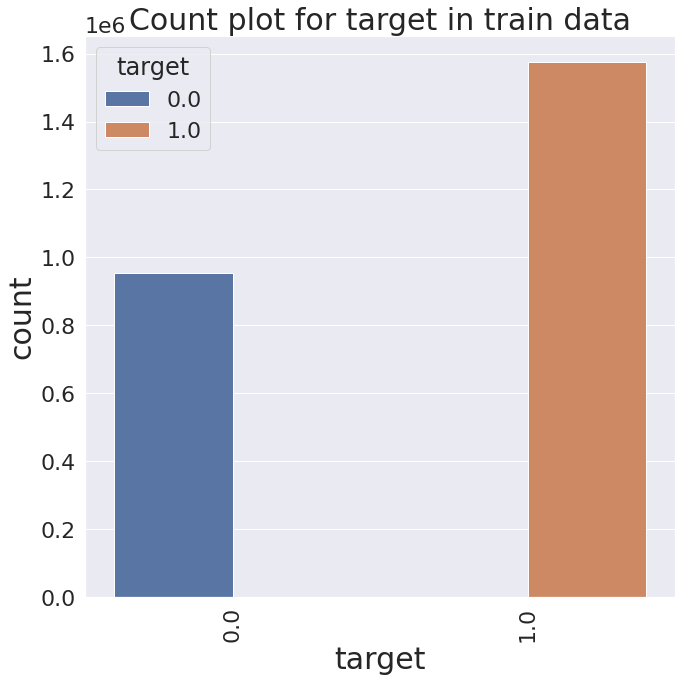

In [9]:
count_plot(train, 'target', 'target', 'train')

In [10]:
print('Data for label 1 : {:.4f}%'.format(train['target'].value_counts()[0]/train.shape[0] * 100))
print('Data for label 0 : {:.4f}%'.format(train['target'].value_counts()[1]/train.shape[0] * 100))

Data for label 1 : 37.7493%
Data for label 0 : 62.2507%


From the above graph we can say that the data is almost balanced.

Label-1 data is around 28.04% and label-0 data is around 71.95%.

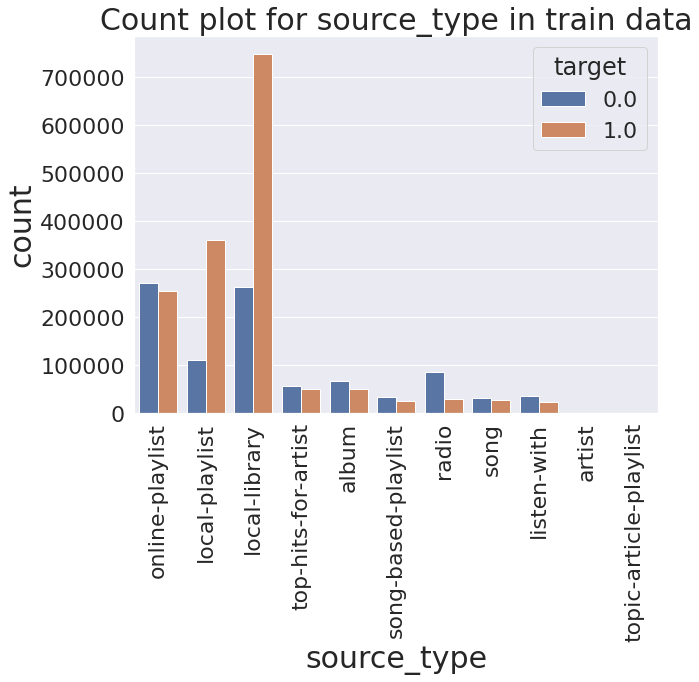

In [11]:
count_plot(train, 'source_type', 'target', 'train')

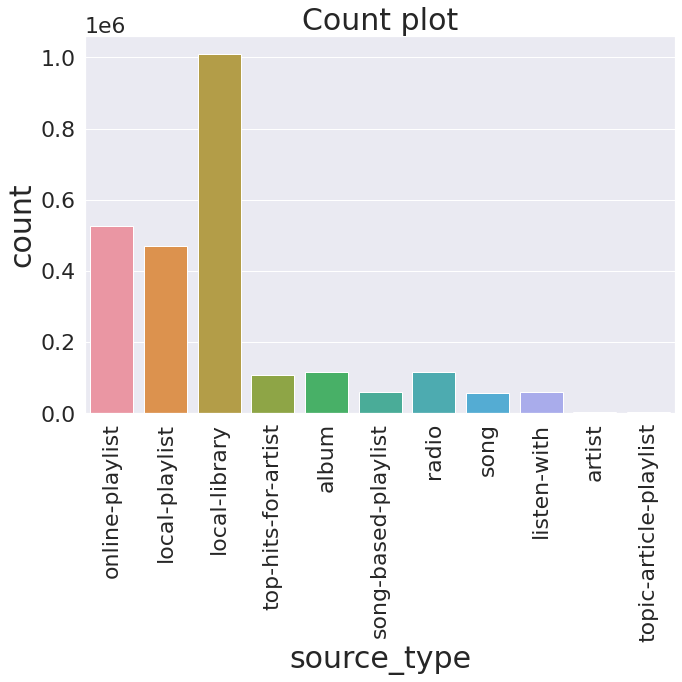

In [12]:
count_plot_function(train, 'source_type')


**source_type** is the entry point, a user first plays music on mobile apps.

From the above graph we can say that, most of the users start playing songs from their local-library, local-playlist or online-playlist.


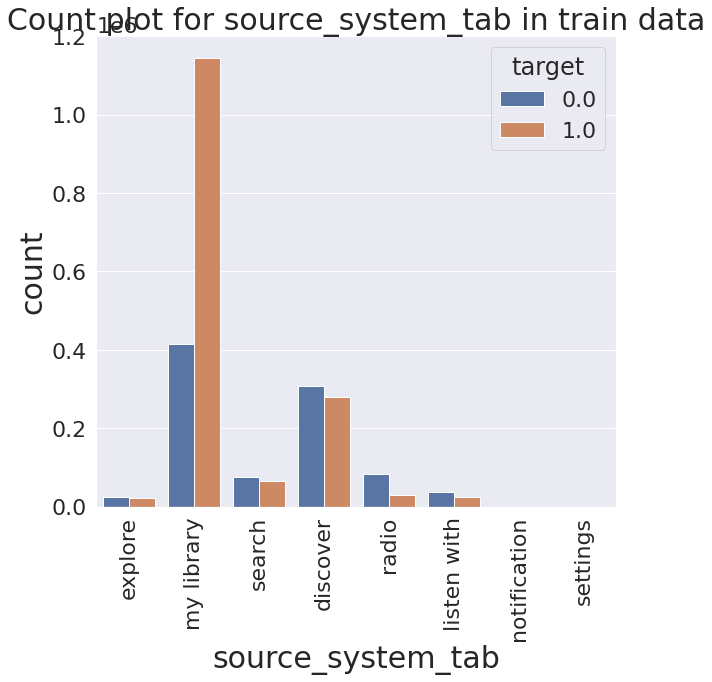

In [13]:
count_plot(train, 'source_system_tab', 'target', 'train')

**source_system_tab** indicates the name of the tab where the event was triggered. 

It can be depicted from the above graph that people play songs on loop from their library or discover tabs.



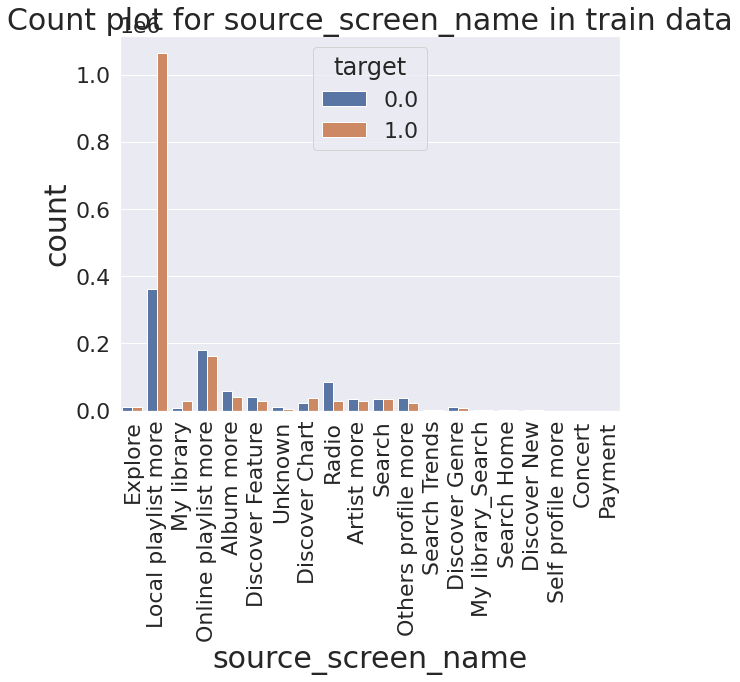

In [14]:
count_plot(train, 'source_screen_name', 'target', 'train')

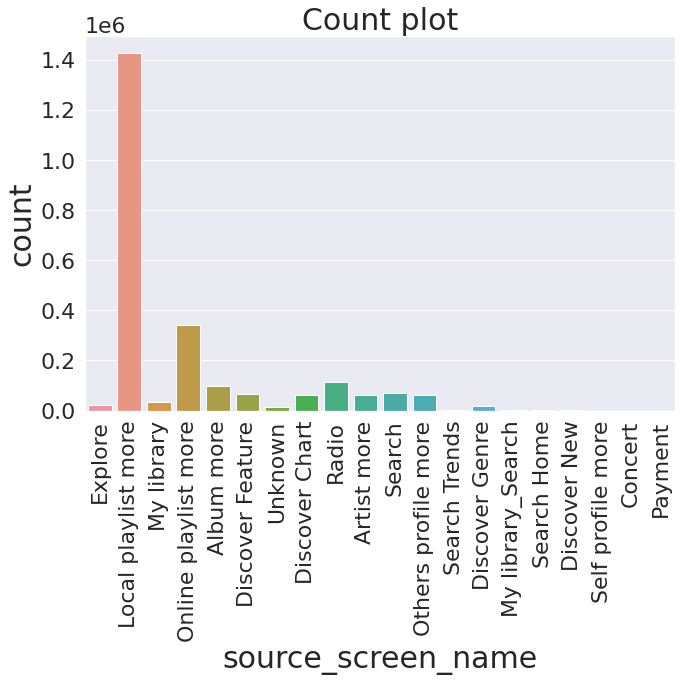

In [15]:
count_plot_function(train, 'source_screen_name')

**source_screen_name **is the name of the layout a user sees.

Most of the users prefer local_playlist or online_playlist_more as their favourite layouts.

**Members** **Data Analysis**

In [16]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   msno                    34403 non-null  object
 1   city                    34403 non-null  int64 
 2   bd                      34403 non-null  int64 
 3   gender                  14501 non-null  object
 4   registered_via          34403 non-null  int64 
 5   registration_init_time  34403 non-null  int64 
 6   expiration_date         34403 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.8+ MB


In [17]:
def count_plot_function(data, x):
  '''Function to plot histograms for categories'''
  plt.figure(figsize=(10,10))
  sns.set(font_scale=2)
  sns.countplot(x=x, data=data)
  plt.xlabel(x,fontsize=30)
  plt.ylabel('count',fontsize=30)
  plt.xticks(rotation='90')
  plt.title('Count plot',fontsize=30)
  plt.tight_layout()

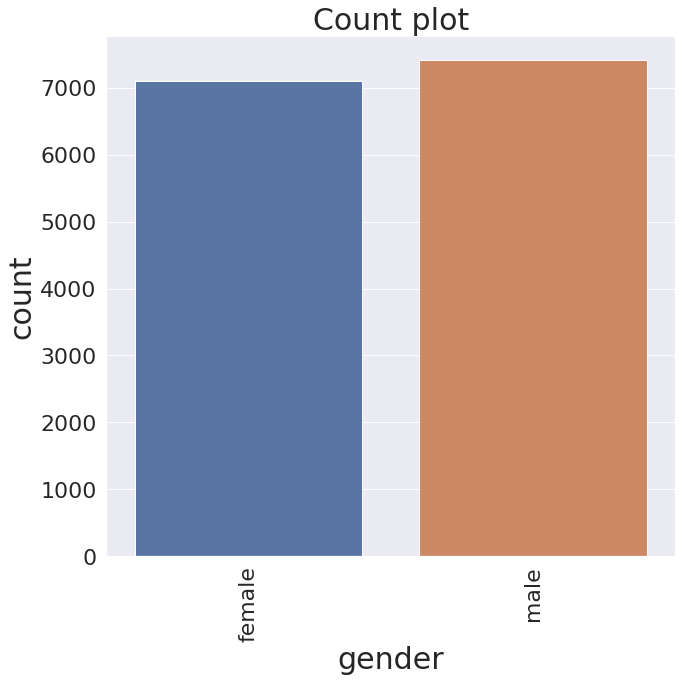

In [18]:
count_plot_function(members, 'gender')

Both male and female users listen to songs almost equally.

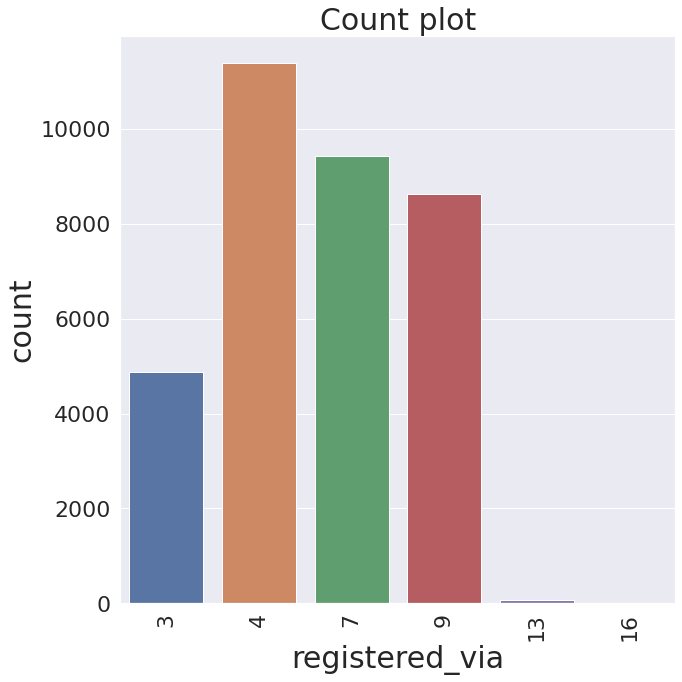

In [19]:
count_plot_function(members, 'registered_via')


Most of the registrations happened via method '4', '7' and '9'.
Few uses have registered theirselves via '13' and '16' methods.

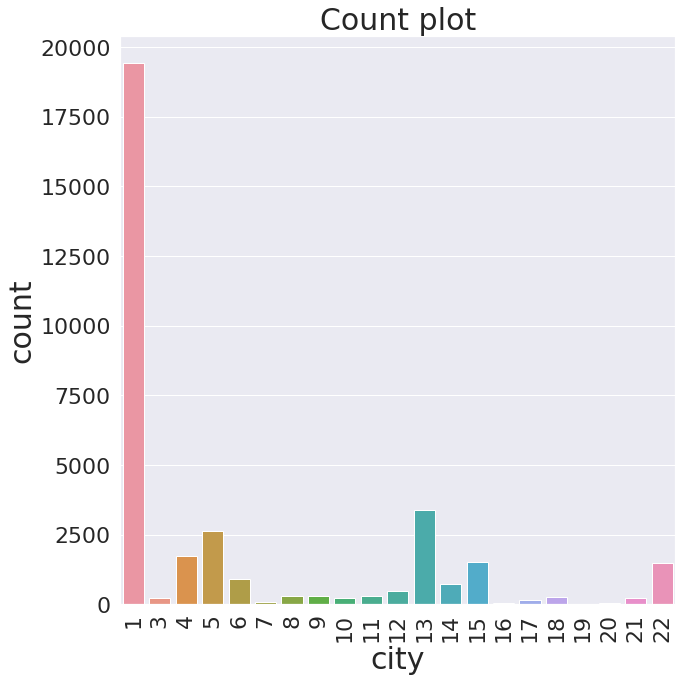

In [20]:
count_plot_function(members, 'city')

Most of the people who used to listen songs are from '1'- labelled city.

Some cities have very few people who prefer listening music via this music app.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'PDF for registration')

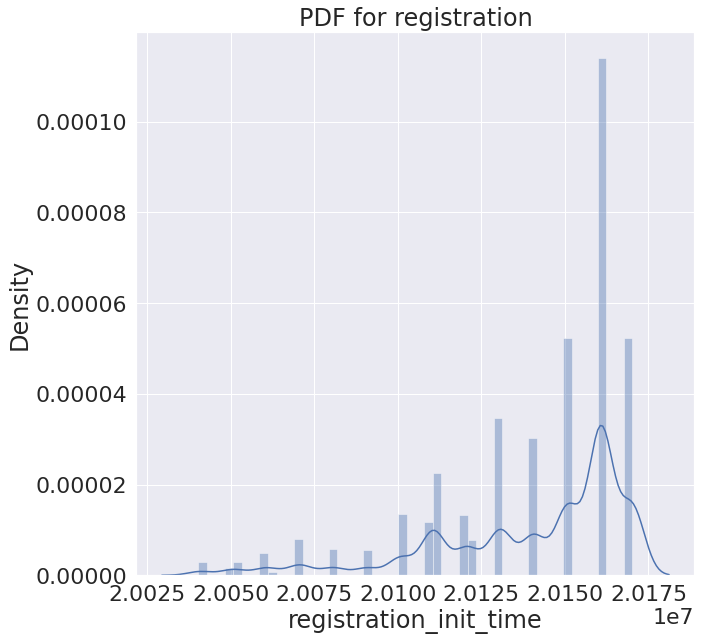

In [21]:
plt.figure(figsize = (10, 10)) 
sns.distplot(members.registration_init_time)
sns.set(font_scale=2)
plt.title('PDF for registration')

 Initially people were not fond of listening to music but gradually over time people started to listen music and registered themselves to this music app.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'PDF for registration')

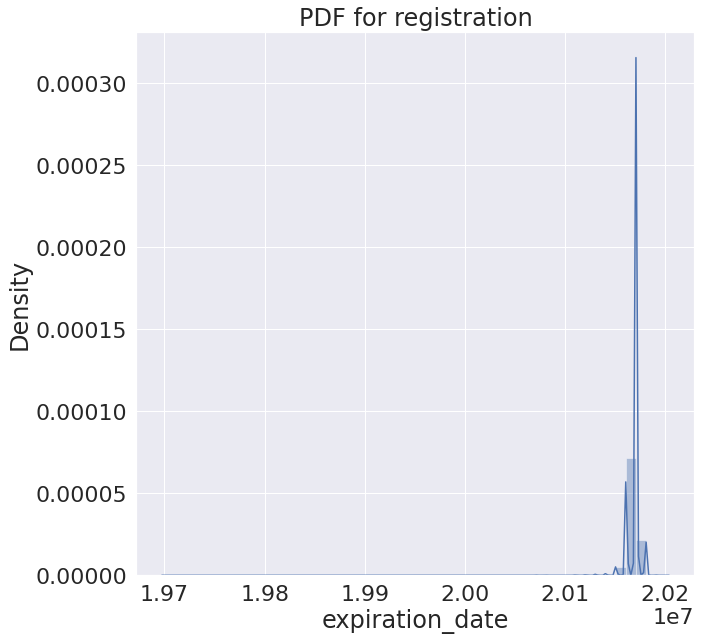

In [22]:
plt.figure(figsize = (10, 10)) 
sns.distplot(members['expiration_date'])
sns.set(font_scale=2)
plt.title('PDF for registration')

 Over time people start registering themselves for the music app, their expiration period also starts increasing after a certain time period.


In [23]:
members.bd.unique()

array([   0,   43,   28,   33,   20,   30,   29,   26,   25,   21,   22,
         16,   23,   37,   18,   19,   51,   24,   17,   45,   36,   57,
         27,   34,   32,   15,   48,   50,   54,   47,   35,   46,   31,
         14,   41,   59,    2,   40,   38,   55,   39,   73,   49,   44,
        103,   52,   70,   42,   65,   56,  101,   58,   53,   64,   63,
         76,   66,   97,    3,   72,   67,   62,   61,  105,   60,   13,
         90,   12,   68,  131,   74,   89,  931,  -38,  144,   85,  112,
         96,   11,  102,   83, 1051,   87,    7,   95,  -43,  111,   93,
          5,   78, 1030,  106,  107,   82,   10])

In [24]:
def plot_pdf_cdf(x, flag):
  '''Function to plot pdf and cdf'''
  plt.figure(figsize = (15, 10)) 
  kwargs = {'cumulative': True}
  if flag:
    sns.distplot(x, hist_kws=kwargs, kde_kws=kwargs)
    plt.title('CDF for age')
  else:
    sns.distplot(x)
    plt.title('PDF for age')
  sns.set(font_scale=2)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


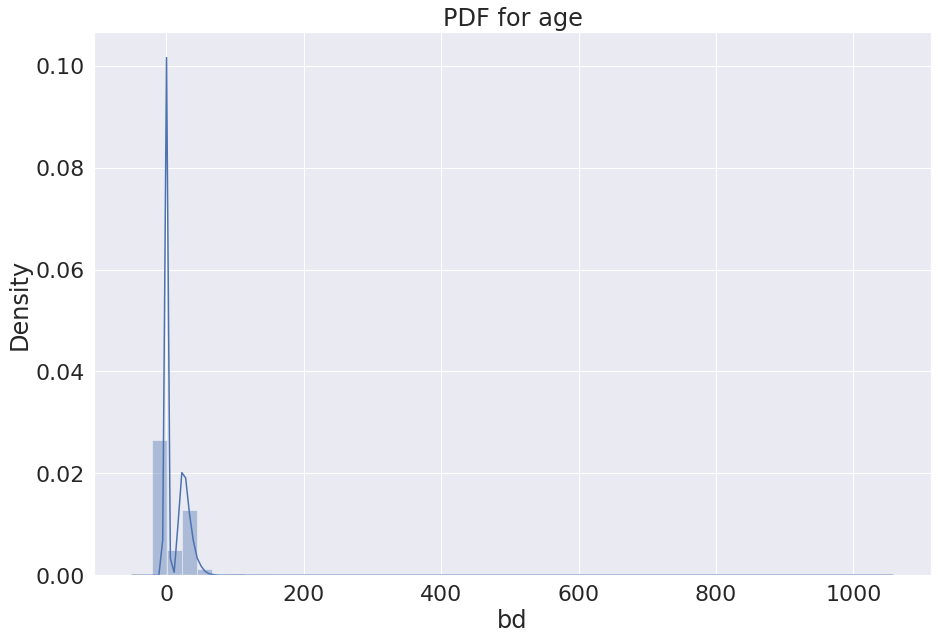

In [25]:
plot_pdf_cdf(members['bd'], False)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


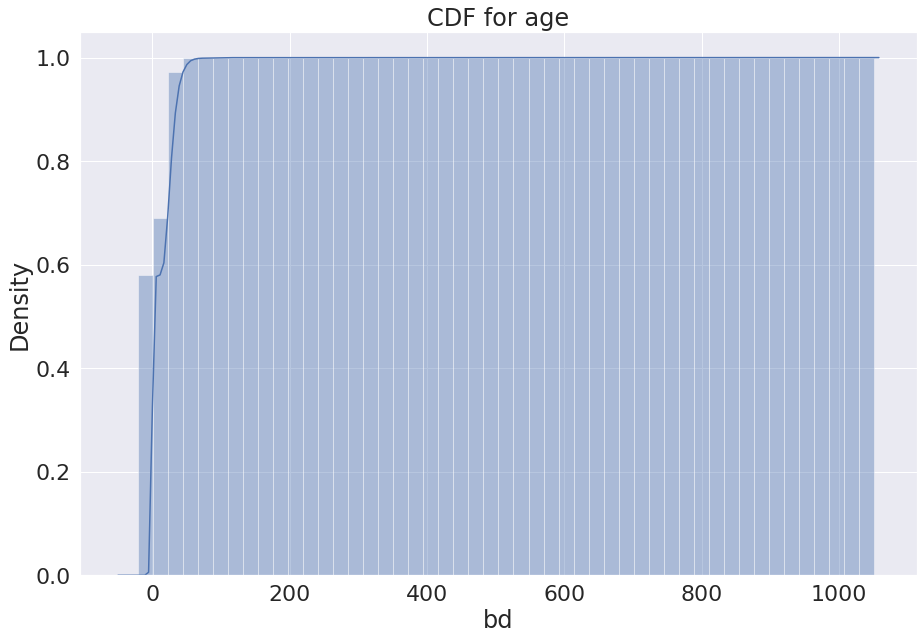

In [26]:
plot_pdf_cdf(members['bd'], True)


In [27]:
np.percentile(members['bd'].values, 98)

47.0

98th percentile user is of 47 age.

Which means most of the user are below 50.

There are also some outliers like 1030, -38, -43, 1051, etc. As age cannot be negative value or more than 1000 for humans.

# Songs data analysis

There are two files which contains information about songs : songs and song_extra_info.
So we merge the files based  on 'song_id' and analyze features in details

In [28]:
song_extra_info

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001
...,...,...,...
2295966,hLnetpF6UbPg28sSfXnPE2vsdaGsLvddlXEdJR4VTIA=,Deep Breathing,PLL431720793
2295967,N+6vJ8actKQm0S3Fpf4elipTjoAo9ev28aA5FJN5e40=,In Hiding,US5UL1519827
2295968,pv35uG0ts05mWtirM/AMOWEzbHxIVart5ZzRXqKUY1c=,Il Est Ne Le Divin Enfant,PLL431502294
2295969,QSySnm8jt2Go7byY34/PxsZP6dPCins2j2cyYquNhBo=,The Exodus Song,DEPZ69316095


In [29]:
songs_all_info = songs.merge(song_extra_info, on='song_id')

In [30]:
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan

songs_all_info['song_year'] = songs_all_info['isrc'].apply(isrc_to_year)

In [31]:
songs_all_info['language'].unique()

array([ 3., 31., 52., 17., 10., -1., 24., 59., 45., 38., nan])

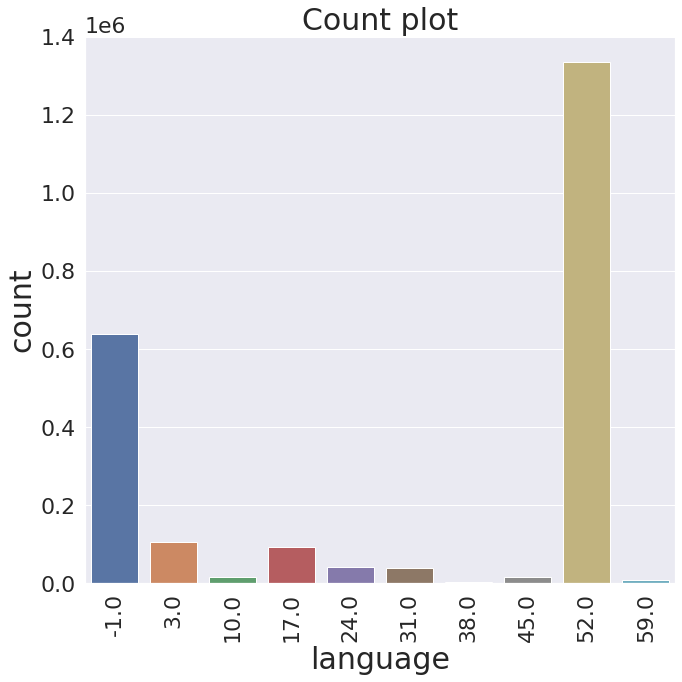

In [32]:
count_plot_function(songs_all_info, 'language')

# Merging of data and analysis



**Missing values**


We will check % of missing values in each column of dataframe.

In [33]:
def check_missing_values(df):
  '''Function to check missing values in df'''
  for col in df.columns:
    nan_count = df[col].isnull().sum()
    total = df.shape[0]
    percentage = nan_count/total * 100
    print(col, 'has {:.2f}% missing values'.format(percentage))

In [34]:
print('Missing values analysis for train data')
check_missing_values(train)

Missing values analysis for train data
msno has 0.00% missing values
song_id has 0.00% missing values
source_system_tab has 0.36% missing values
source_screen_name has 4.87% missing values
source_type has 0.29% missing values
target has 0.00% missing values


In [35]:
print('Missing values analysis for memebrs data')
check_missing_values(members)

Missing values analysis for memebrs data
msno has 0.00% missing values
city has 0.00% missing values
bd has 0.00% missing values
gender has 57.85% missing values
registered_via has 0.00% missing values
registration_init_time has 0.00% missing values
expiration_date has 0.00% missing values


In [36]:
print('Missing values analysis for songs data')
check_missing_values(songs)

Missing values analysis for songs data
song_id has 0.00% missing values
song_length has 0.00% missing values
genre_ids has 4.10% missing values
artist_name has 0.00% missing values
composer has 46.66% missing values
lyricist has 84.71% missing values
language has 0.00% missing values


In [37]:
print('Missing values analysis for songs_all_info data')
check_missing_values(songs_all_info)

Missing values analysis for songs_all_info data
song_id has 0.00% missing values
song_length has 0.00% missing values
genre_ids has 4.10% missing values
artist_name has 0.00% missing values
composer has 46.66% missing values
lyricist has 84.71% missing values
language has 0.00% missing values
name has 0.00% missing values
isrc has 5.95% missing values
song_year has 5.95% missing values


The train data has over all missing values below 5%.

In members data 'gender' feature has 57.85% missing values.

Songs has 'composer' and 'lyricist' features which contains 45.2% and 81.03% missing values respectively.

In [38]:
train_members = pd.merge(train, members, on='msno', how='left')
train_merged = pd.merge(train_members, songs_all_info, on='song_id', how='left')

In [39]:
test_members = pd.merge(test, members, on='msno', how='left')
test_merged = pd.merge(test_members, songs_all_info, on='song_id', how='left')

In [40]:
del train_members
del test_members

In [41]:
check_missing_values(train_merged)

msno has 0.00% missing values
song_id has 0.00% missing values
source_system_tab has 0.36% missing values
source_screen_name has 4.87% missing values
source_type has 0.29% missing values
target has 0.00% missing values
city has 0.00% missing values
bd has 0.00% missing values
gender has 39.35% missing values
registered_via has 0.00% missing values
registration_init_time has 0.00% missing values
expiration_date has 0.00% missing values
song_length has 0.01% missing values
genre_ids has 1.47% missing values
artist_name has 0.01% missing values
composer has 21.98% missing values
lyricist has 41.95% missing values
language has 0.01% missing values
name has 0.01% missing values
isrc has 7.81% missing values
song_year has 7.81% missing values


After merging we can say that, 'gender' feature has 39.6%, 'composer' has 48.5% and 'lyricist' has 61.29% missing values.


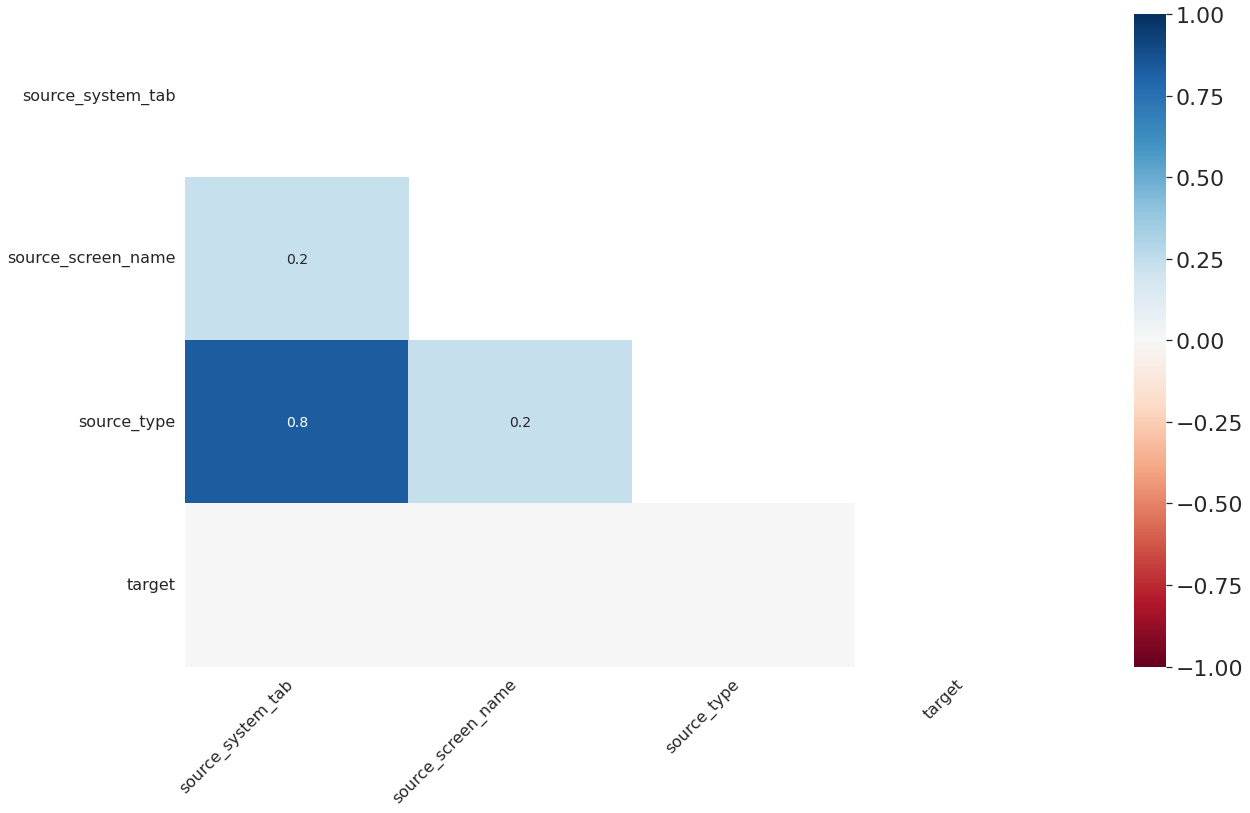

In [42]:
msno.heatmap(train)

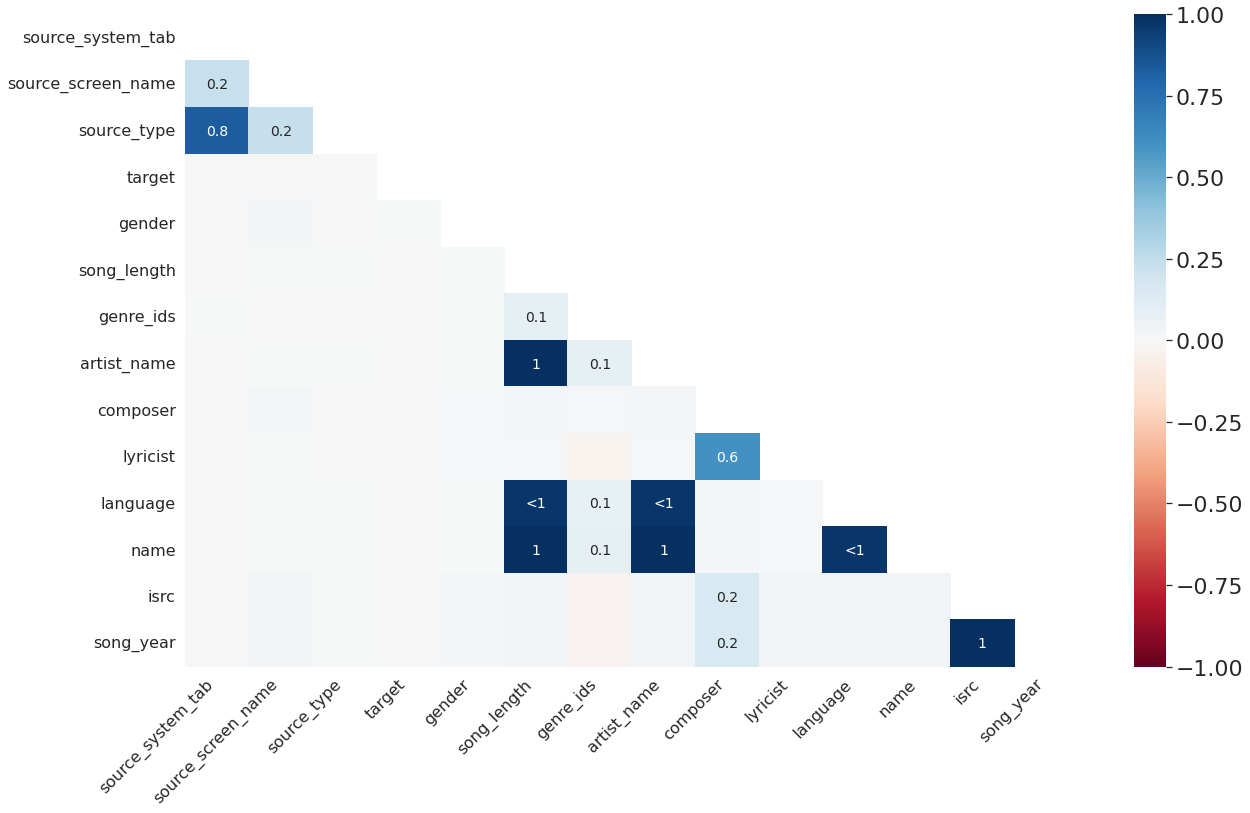

In [43]:
msno.heatmap(train_merged)

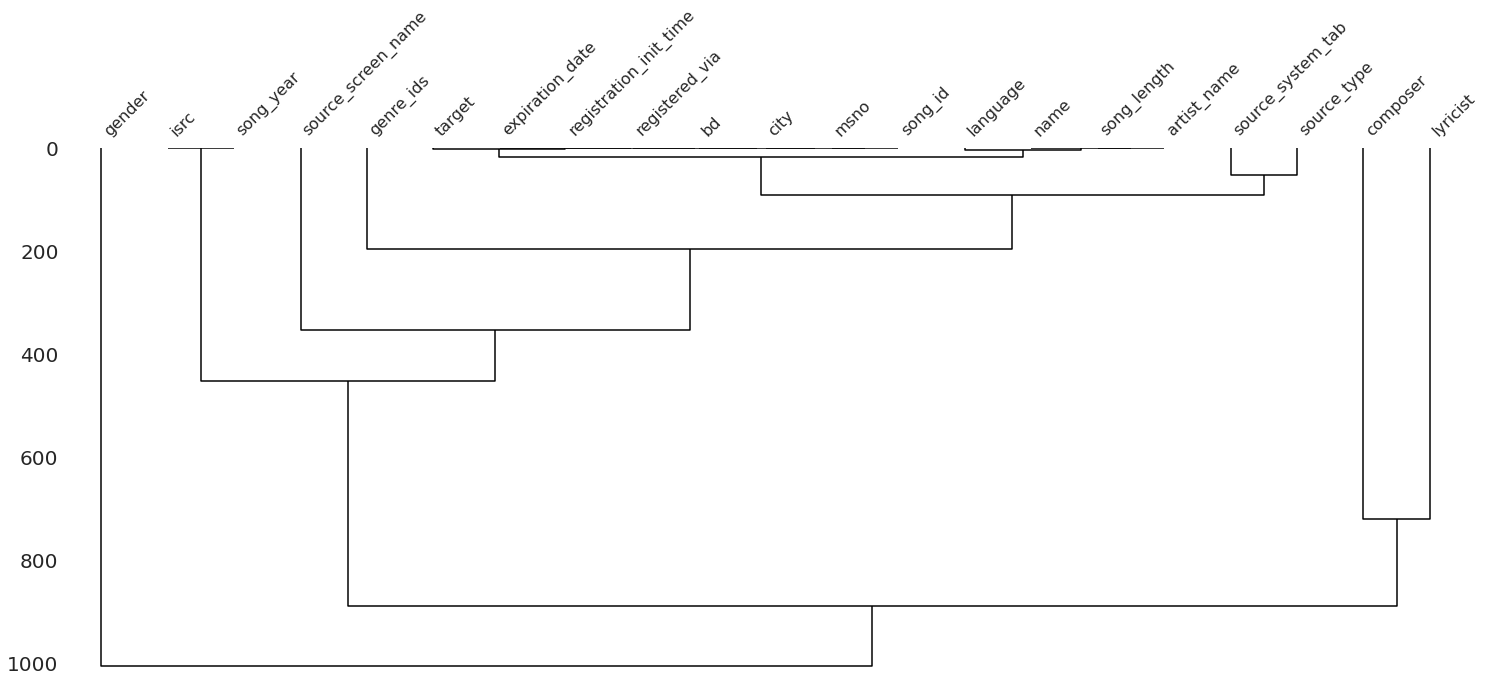

In [44]:
msno.dendrogram(train_merged)


composer -> lyricst

source_system_tab -> source_type

lanugage -> song_length, artist_name, name

isrc -> song_year

# Feature Engineering

We have train, test, members, songs and songs_extra_info files.

We will extract individual independent features from members, songs and songs_extra.

We will extract dependent features on train and val data after splitting to avoid data leakage problem.

In [45]:
del train, test, members, songs, song_extra_info

In [46]:
import time
import numpy as np
import pandas as pd
import lightgbm as lgb
import gc

In [47]:
data_path = '/content/drive/My Drive/CS-1/Data/'

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
members = pd.read_csv(data_path + 'members.csv')
songs = pd.read_csv(data_path + 'songs.csv')
songs_extra = pd.read_csv(data_path + 'song_extra_info.csv')
train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')

# Splitting data

In [50]:
# As the data is oredered in chronological order so, we will take 80% train and 20% val data from train data
tr_index = train.shape[0] * 8 // 10

In [51]:
train_data = train.iloc[:tr_index]
val_data = train.iloc[tr_index:]
print(train_data.shape, val_data.shape, test.shape)

(5901934, 6) (1475484, 6) (2556790, 6)


# Merge data with members, songs and songs_extra

In [52]:
# merge with members

train_members = pd.merge(train_data, members, on='msno', how='left')
val_members = pd.merge(val_data, members, on='msno', how='left')
test_members = pd.merge(test, members, on='msno', how='left')

In [53]:
songs_all = pd.merge(songs, songs_extra, on='song_id', how='left')

In [54]:
# merge with members
train_all = pd.merge(train_members, songs_all, on='song_id', how='left')
val_all = pd.merge(val_members, songs_all, on='song_id', how='left')
test_all = pd.merge(test_members, songs_all, on='song_id', how='left')

In [55]:
del train_members
del val_members
del test_members
del songs_all

In [56]:
del train_data
del val_data

In [57]:
del train, test

# F.E. for Members

Members dataframe has registration and expiration dates, from which we can extract features like membership time, individual day, month and year.

From analysis of 'bd' feature we noticed some oputliers like negetive and higher values of ages, which we can remove.

In [58]:
#feature engineering for members

def filter_age(x):
  # 98th percentile is 47
  '''Function to fix age value between 0 to 75'''
  if x >= 0 and x <= 75:
    return x
  else:
    return np.nan

train_all['bd'] = train_all['bd'].apply(filter_age)
val_all['bd'] = val_all['bd'].apply(filter_age)
test_all['bd'] = test_all['bd'].apply(filter_age)

In [59]:
def extract_date_fatures(data):
  '''Function to extract features like day, month, year from dates.'''
  # convert into date format
  data['expiration_date'] = pd.to_datetime(data['expiration_date'], format='%Y%m%d')
  data['registration_init_time'] = pd.to_datetime(data['registration_init_time'], format='%Y%m%d')
  
  # get membership period from registration and expiration dates
  data['membership_days'] = data['expiration_date'].subtract(data['registration_init_time']).dt.days.astype(int)

  # extract year, month and day from dates
  data['registration_year'] = data['registration_init_time'].dt.year
  data['registration_month'] = data['registration_init_time'].dt.month
  data['registration_day'] = data['registration_init_time'].dt.day

  data['expiration_year'] = data['expiration_date'].dt.year
  data['expiration_month'] = data['expiration_date'].dt.month
  data['expiration_day'] = data['expiration_date'].dt.day

  return data

train_all = extract_date_fatures(train_all)
val_all = extract_date_fatures(val_all)
test_all = extract_date_fatures(test_all)

## F.E for Songs

 Songs has 'lyricist' and 'composer' features which have more than 20% of missing values.

  So we ignore these two features and fill the missing values in the remaining features.

In [60]:
#Feature engineering for songs
train_all.tail(3)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,membership_days,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day
5901931,+fzJ5Uou/rxl1pXlebOEBHFKC4LBwDfgnc2R7287CVs=,b8Ec5KHbhiJc+Aeg4hgVx7mkdk5UlDZyW48Y1OfyqBU=,my library,Local playlist more,local-library,1,1,18.0,female,3,2015-03-21,2017-10-05,214517.0,465,劉思涵 (Koala Liu),王于陞,安立奎,3.0,走在冷風中,TWF711100078,929,2015,3,21,2017,10,5
5901932,+fzJ5Uou/rxl1pXlebOEBHFKC4LBwDfgnc2R7287CVs=,fwaxN4NL0q27tHQq4VEPCKVTywMIGqImrgRvFLnrVJw=,my library,Local playlist more,local-library,1,1,18.0,female,3,2015-03-21,2017-10-05,283167.0,465,楊培安 (Roger Yang),Du Zhi Wen,Qian Zi,3.0,說好各走五十步,TWA531302103,929,2015,3,21,2017,10,5
5901933,+fzJ5Uou/rxl1pXlebOEBHFKC4LBwDfgnc2R7287CVs=,yqZjiUmLn/+h6g047I0LNxX3UoS60z3PJacJOFcxFMU=,my library,Local playlist more,local-library,0,1,18.0,female,3,2015-03-21,2017-10-05,204335.0,359,Tegan And Sara,NaN,NaN,52.0,I Was a Fool,USWB11203029,929,2015,3,21,2017,10,5


In [61]:
train_all.isnull().any()

msno                      False
song_id                   False
source_system_tab          True
source_screen_name         True
source_type                True
target                    False
city                      False
bd                         True
gender                     True
registered_via            False
registration_init_time    False
expiration_date           False
song_length                True
genre_ids                  True
artist_name                True
composer                   True
lyricist                   True
language                   True
name                       True
isrc                       True
membership_days           False
registration_year         False
registration_month        False
registration_day          False
expiration_year           False
expiration_month          False
expiration_day            False
dtype: bool

In [62]:
train_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5901934 entries, 0 to 5901933
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   msno                    object        
 1   song_id                 object        
 2   source_system_tab       object        
 3   source_screen_name      object        
 4   source_type             object        
 5   target                  int64         
 6   city                    int64         
 7   bd                      float64       
 8   gender                  object        
 9   registered_via          int64         
 10  registration_init_time  datetime64[ns]
 11  expiration_date         datetime64[ns]
 12  song_length             float64       
 13  genre_ids               object        
 14  artist_name             object        
 15  composer                object        
 16  lyricist                object        
 17  language                float64       
 18  na

In [63]:
# Filling missing values
def filling_missing_values(data):
  data['source_system_tab'].fillna('no_system_tab', inplace=True)
  data['source_screen_name'].fillna('no_screen_name', inplace=True)
  data['source_type'].fillna('np_source_type', inplace=True)
  data['bd'].fillna(0, inplace=True)
  data['gender'].fillna('gender_missing', inplace=True)
  data['song_length'].fillna(0, inplace=True)
  data['genre_ids'].fillna(0, inplace=True)
  data['lyricist'].fillna('no_lyricist', inplace=True)
  data['artist_name'].fillna('no_artist_name', inplace=True)
  data['composer'].fillna('no_composer', inplace=True)
  data['language'].fillna('no_language', inplace=True)
  data['name'].fillna('no_name', inplace=True)
  return data

train_all = filling_missing_values(train_all)
val_all = filling_missing_values(val_all)
test_all = filling_missing_values(test_all)

# F.E. for Genre

Some genre_ids have more than one value which are seperated by '|'.

We can extract features from genre_ids like total_count of genres,
we can also seperate genre_ids in-to individual columns. To achieve this we will consider more than 2 genre_ids_count.

In [64]:
def generate_genre_ids(data):
  '''Function to sepearate each genre_id and count total number of genre_ids'''
  genre_ids_matrix = np.zeros((data.shape[0], 4))

  for i in range(data.shape[0]):
    ids = str(data['genre_ids'].values[i]).split('|')
    if len(ids) > 2:
        genre_ids_matrix[i, 0] = (ids[0])
        genre_ids_matrix[i, 1] = (ids[1])
        genre_ids_matrix[i, 2] = (ids[2])
    elif len(ids) > 1:
        genre_ids_matrix[i, 0] = (ids[0])
        genre_ids_matrix[i, 1] = (ids[1])
    elif len(ids) == 1:
        genre_ids_matrix[i, 0] = (ids[0])
    genre_ids_matrix[i, 3] = len(ids)

  data['first_genre_id'] = genre_ids_matrix[:, 0] # keeps first genre_id
  data['second_genre_id'] = genre_ids_matrix[:, 1] # keeps second genre_id
  data['third_genre_id'] = genre_ids_matrix[:, 2] # keeps third genre_id
  data['genre_ids_count'] = genre_ids_matrix[:, 3] # keeps count of genre_ids
  return data

In [65]:
train_all = generate_genre_ids(train_all)
val_all = generate_genre_ids(val_all)
test_all = generate_genre_ids(test_all)

We will drop 'composer' and 'lyricist' as they contain higher missing values.

In [66]:
train_all = train_all.drop(['composer', 'lyricist'], axis=1)
val_all = val_all.drop(['composer', 'lyricist'], axis=1)
test_all = test_all.drop(['composer', 'lyricist'], axis=1)

# F.E for Artist

A few songs has 'feat' included in their artist names. We will add another column with boolean value based on 'feat' presents or not.
If more than one artists are present in the song then their names are seperated by & and ,
We will add extra features like is_featured, artist_count, first_artist_name.

In [67]:
def calculate_is_featured(data):
  '''Function to check 'feat' in artist field.'''
  data['is_featured'] = data['artist_name'].apply(lambda x: 1 if ' feat' in str(x) else 0).astype(np.int8)
  return data

In [68]:
train_all = calculate_is_featured(train_all)
val_all = calculate_is_featured(val_all)
test_all = calculate_is_featured(test_all)

In [69]:
def artist_count(x):
  '''Function to count total number of artists for each song'''
  return x.count('and') + x.count(',') + x.count(' feat') + x.count('&') + 1

def get_first_artist(x):
  '''Function to extract first artist name from more than one artists'''
  if x.count('and') > 0:
    x = x.split('and')[0]
  if x.count(',') > 0:
    x = x.split(',')[0]
  if x.count(' feat') > 0:
    x = x.split(' feat')[0]
  if x.count('&') > 0:
    x = x.split('&')[0]
  return x.strip()

In [70]:
def calculate_artist_features(data):
  '''Function to execute above both functions'''
  # get artist count 
  data['artist_count'] = data['artist_name'].apply(artist_count).astype(np.int8)
  # get first artist name
  data['first_artist_name'] = data['artist_name'].apply(get_first_artist)
  return data

In [71]:
train_all = calculate_artist_features(train_all)
val_all = calculate_artist_features(val_all)
test_all = calculate_artist_features(test_all)

# F.E. for Extra

We will add boolean feature for songs, if song comes from '17' or '45' language then we will set boolean feature.
We will calculate mean length of song from train songs and will set the song's size as an extra boolean feature either smaller than mean or not.

In [72]:
#feature engineering for extra
def song_lang_boolean(x):
  '''Function to add language boolean feature'''
  if 17.0 == str(x) or 45.0 == str(x):
    return 1
  else:
    return 0
    
mean_song_length = np.mean(train_all['song_length'])
def smaller_song(x):
  '''Function to add song_size boolean feature'''
  if x < mean_song_length:
    return 1
  else:
    return 0

In [73]:
def calculate_language_features(data):
  data['song_lang_boolean'] = data['language'].apply(song_lang_boolean).astype(np.int8)
  data['song_size_boolean'] = data['song_length'].apply(smaller_song).astype(np.int8)
  return data

In [74]:
train_all = calculate_language_features(train_all)
val_all = calculate_language_features(val_all)
test_all = calculate_language_features(test_all)

# F.E for songs_extra

songs_extra file has feature like 'isrc' which is International Standard Recording Code. For each song its isrc is unique which contains information like countr_code, registraion_code, year of reference and designation code.

https://isrc.ifpi.org/en/isrc-standard/code-syntax

We can extract features like country_code, registration_code and song_year from 'isrc' feature.

In [75]:
#Feature engineering for songs_extra
def calcualte_songs_features(data):
  '''Function to extract features from isrc.'''
  isrc = data['isrc']
  data['country_code'] = isrc.str.slice(0, 2)
  data['registration_code'] = isrc.str.slice(2, 5)
  data['song_year'] = isrc.str.slice(5, 7).astype(float)
  data['song_year'] = data['song_year'].apply(lambda x: 2000+x if x < 18 else 1900+x)
  data['isrc_missing'] = (data['country_code'] == 0) * 1.0
  return data

In [76]:
train_all = calcualte_songs_features(train_all)
val_all = calcualte_songs_features(val_all)
test_all = calcualte_songs_features(test_all)

In [77]:
def filling_missing_isrc_values(data):
  '''Function to fill missing isrc values'''
  data['isrc'].fillna('no_isrc', inplace=True)
  data['country_code'].fillna('no_country_code', inplace=True)
  data['registration_code'].fillna('no_registration_code', inplace=True)
  data['song_year'].fillna('no_song_year', inplace=True)
  return data

train_all = filling_missing_isrc_values(train_all)
val_all = filling_missing_isrc_values(val_all)
test_all = filling_missing_isrc_values(test_all)

In [78]:
val_all.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date', 'song_length', 'genre_ids',
       'artist_name', 'language', 'name', 'isrc', 'membership_days',
       'registration_year', 'registration_month', 'registration_day',
       'expiration_year', 'expiration_month', 'expiration_day',
       'first_genre_id', 'second_genre_id', 'third_genre_id',
       'genre_ids_count', 'is_featured', 'artist_count', 'first_artist_name',
       'song_lang_boolean', 'song_size_boolean', 'country_code',
       'registration_code', 'song_year', 'isrc_missing'],
      dtype='object')

In [79]:
train_all = train_all.drop(['genre_ids', 'artist_name','isrc', 'registration_init_time', 'expiration_date'], axis=1)
val_all = val_all.drop(['genre_ids', 'artist_name' ,'isrc', 'registration_init_time', 'expiration_date'], axis=1)
test_all = test_all.drop(['genre_ids', 'artist_name','isrc', 'registration_init_time', 'expiration_date'], axis=1)

# Group by features

 People over 40 years are fond of hindi soothing or bollywood classics rather than english pop 

Using group by we can extract some features based on user's choices like song_count (for each song how many times he/she listens), artist_count (for each artist how many number of users or songs are present in our dataset.)

We will extract theese types of group by features according to train, val and test data seperately to avoid data leakage issues.

In [80]:
def calculate_groupby_features(data):
  '''Function to calculate group by features on dataframe '''
  # song count for each user
  member_song_count = data.groupby('msno').count()['song_id'].to_dict()
  data['member_song_count'] = data['msno'].apply(lambda x: member_song_count[x])

  # song count for each artist
  artist_song_count = data.groupby('first_artist_name').count()['song_id'].to_dict()
  data['artist_song_count'] = data['first_artist_name'].apply(lambda x: artist_song_count[x])

  # song count for each genre_id
  first_genre_id_song_count = data.groupby('first_genre_id').count()['song_id'].to_dict()
  data['genre_song_count'] = data['first_genre_id'].apply(lambda x: first_genre_id_song_count[x])

  # song count for each lanugage
  lang_song_count = data.groupby('language').count()['song_id'].to_dict()
  data['lang_song_count'] = data['language'].apply(lambda x: lang_song_count[x])

  # user count for each song
  song_member_count = data.groupby('song_id').count()['msno'].to_dict()
  data['song_member_count'] = data['song_id'].apply(lambda x: song_member_count[x])

  # We can add group by  wrt 'age'
  age_song_count = data.groupby('bd').count()['song_id'].to_dict()
  data['age_song_count'] = data['bd'].apply(lambda x: age_song_count[x])
 
  return data

In [81]:
train_all = calculate_groupby_features(train_all)
val_all = calculate_groupby_features(val_all)
test_all = calculate_groupby_features(test_all)

In [82]:
save_path = '/content/drive/My Drive/CS-1/'

train_all.to_csv(save_path + 'train_all_new.csv', index=False)
val_all.to_csv(save_path + 'val_all_new.csv', index=False)
test_all.to_csv(save_path + 'test_all_new.csv', index=False)

# Summary

**EDA**

We have analyzed each and every feature from train and validation dataset with the help of different plots like barplot, PDF and CDF.
We have also analyzed missing values and their percentages in features.

 **Feature Engineering**

From songs, songs_extra_info and members we have combined all information related to user and songs and extracted various features.
We have extracted features like membership days, information of year, month and day from registration and expiration dates.
We have also extracted groupby features for songs and users with respect to artist, lyricist, composer, language, age etc.
We have extracted features like song year, country code, registration code from isrc code for each and every song. Along with that we have extracted counts like artist count, genre count, lyricist count, composer count etc.